### DVAE (VRNN architecture)

Here is a first implementation of a DVAE for the MOVING MNIST dataset.

In [1]:
import scipy
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300
# we want to use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
# import data from the moving mnist dataset
data = np.load('data/bouncing_mnist_test.npy')

# normalize the data to be between 0 and 1 (better training performance for some reason)
data = data / 255

data.shape

(10000, 20, 64, 64)

In [3]:
class Encoder(nn.Module):
    def __init__(self,hidden_size=128,RNN_dim=128,latent_size=32):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2)

        self.fc_x_enc = nn.Linear(2*2*256, hidden_size)

        self.enc_mean = nn.Linear(hidden_size + RNN_dim, latent_size)
        self.enc_logvar = nn.Linear(hidden_size + RNN_dim, latent_size)

    def reparametrization(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + std * eps

    def forward(self,x,h):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        phi_x = F.relu(self.fc_x_enc(x))

        encoder_input = torch.cat((phi_x,h),dim=1)

        z_mean = self.enc_mean(encoder_input)
        z_logvar = self.enc_logvar(encoder_input) 
        z = self.reparametrization(z_mean,z_logvar)

        return phi_x, z, z_mean, z_logvar

class Decoder(nn.Module):
    def __init__(self,hidden_size=128,RNN_dim=128,latent_size=32):
        super().__init__()

        self.fc_z_dec_1 = nn.Linear(latent_size, 64)
        self.fc_z_dec_2 = nn.Linear(64, hidden_size)
        self.fc_z_dec_3 = nn.Linear(hidden_size + RNN_dim, 1024)

        self.deconv1 = nn.ConvTranspose2d(1024, 128, 5, stride=2)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(32, 1, 6, stride=2)

    def forward(self,z,h):

        z = F.relu(self.fc_z_dec_1(z))
        phi_z = F.relu(self.fc_z_dec_2(z))
        decoder_input = torch.cat((phi_z,h),dim=1)
        x_rec = F.relu(self.fc_z_dec_3(decoder_input))
        x_rec = x_rec.unsqueeze(-1).unsqueeze(-1)
        x_rec = F.relu(self.deconv1(x_rec))
        x_rec = F.relu(self.deconv2(x_rec))
        x_rec = F.relu(self.deconv3(x_rec))
        x_rec = torch.sigmoid(self.deconv4(x_rec))
        return phi_z, x_rec


class VRNN(nn.Module):

    def __init__(self,hidden_size=128,RNN_dim=128,latent_size=32):

        super(VRNN, self).__init__()

        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.rnn_dim = RNN_dim

        self.image_size=64

        self.encoder = Encoder(hidden_size,RNN_dim,latent_size)
        self.decoder = Decoder(hidden_size,RNN_dim,latent_size)

        # encoding the prior on the latent space given previous dynamics
        self.prior_encoder = nn.Sequential(
                                            nn.Linear(RNN_dim, hidden_size),
                                            nn.Linear(hidden_size, 64 ),
                                            nn.Tanh())
        self.prior_mean = nn.Linear(64, latent_size)
        self.prior_logvar = nn.Linear(64, latent_size)

        # RNN part of the model, encode the dynamics of the latent space
        self.rnn = nn.RNN(2*hidden_size, RNN_dim)

    def forward(self,x):

        seq_len, batch_size,_,_ = x.shape

        # create variable holder
        self.z_mean = torch.zeros(seq_len, batch_size, self.latent_size).to(device)
        self.z_logvar = torch.zeros(seq_len, batch_size, self.latent_size).to(device)
        self.z = torch.zeros(seq_len, batch_size, self.latent_size).to(device)

        h = torch.zeros((seq_len, batch_size, self.rnn_dim)).to(device)
        z_t = torch.zeros((batch_size, self.latent_size)).to(device)
        h_t = torch.zeros((batch_size, self.rnn_dim)).to(device) # the initial hidden state coudl be different from 0 ... (random ?)

        y = torch.zeros((seq_len, batch_size, self.image_size,self.image_size)).to(device) # observation reconstruction
        
        for t in range(seq_len):

            x_t = x[t,:,:,:].unsqueeze(1)

            # encode the observtion -> infer the latent state
            phi_x_t, z_t, mean_zt, logvar_zt = self.encoder(x_t, h_t)

            # reconstruct the observation -> generate an observation
            phi_z_t, y_t = self.decoder(z_t,h_t)

            rnn_input = torch.cat((phi_x_t,phi_z_t),dim=1)

            # rnn or lstm ?
            h_t = self.rnn(rnn_input.unsqueeze(0),h_t.unsqueeze(0))[1].squeeze(0)

            # save variable
            y[t,:,:,:] = y_t.squeeze(1)
            self.z_mean[t,:,:] = mean_zt
            self.z_logvar[t,:,:] = logvar_zt
            self.z[t,:,:] = z_t
            h[t,:,:] = h_t

        # generation of the latent variable z prior (for the KL divergence)
        prior_encoder_output = self.prior_encoder(h)
        self.z_prior_mean = self.prior_mean(prior_encoder_output)
        self.z_prior_logvar = self.prior_logvar(prior_encoder_output)

        return y,  self.z_mean, self.z_logvar, self.z_prior_mean, self.z_prior_logvar, self.z

In [4]:
mseLoss = torch.nn.MSELoss()

def loss_function(x_reconstructed, x, mean, logvar, mean_prior=None, logvar_prior=None):
    if mean_prior is None :
        mean_prior = torch.zeros_like(mean)
    if logvar_prior is None :
        logvar_prior = torch.zeros_like(logvar)
    # reconstruction loss
    # recon_loss = mseLoss(x_reconstructed,x)
    recon_loss = F.binary_cross_entropy(x_reconstructed, x, size_average=False)
    # KL divergence
    kl_loss = -0.5 * torch.sum(logvar - logvar_prior - torch.div((logvar.exp() + (mean - mean_prior).pow(2)), logvar_prior.exp()+1e-10))
    return recon_loss + kl_loss

def count_parameters(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

def kl_dist(logvar1,mean1,logvar2,mean2):
    return -0.5 * torch.sum(logvar1 - logvar2 - torch.div((logvar1.exp() + (mean1 - mean2).pow(2)), logvar2.exp()+1e-10))

In [5]:
# parameters
hidden_size = 128
latent_size = 32
RNN_dim = 64

vrnn = VRNN(hidden_size= hidden_size, latent_size= latent_size, 
            RNN_dim=RNN_dim)
vrnn = vrnn.to(device)
opt = torch.optim.Adam(vrnn.parameters(),lr = 1e-4)
count_parameters(vrnn)

4638785

In [6]:
batch_size= 64

train_loader = torch.utils.data.DataLoader(
                 dataset=data,
                 batch_size=batch_size,
                 shuffle=True)

def train(nb_epochs=1,batch_size=128):
    for epoch in range(nb_epochs):
        pbar = tqdm(train_loader)
        pbar.set_description("epoch %s/ loss=? " % str(epoch+1))
        for x in pbar:
            x = torch.reshape(x,(20,-1,64,64)).float().to(device)
            opt.zero_grad()
            y, mean, logvar, mean_prior, logvar_prior, z = vrnn.forward(x)
            loss = loss_function(y,x,mean,logvar,mean_prior,logvar_prior)
            loss.backward()
            opt.step()
            pbar.set_description("epoch "+str(epoch+1)+"/"+str(nb_epochs)+"/ loss= "+str(loss.cpu().detach().numpy()) )

In [130]:
train(nb_epochs=100,batch_size=batch_size)

epoch 1/ loss=? :   0%|          | 0/157 [00:00<?, ?it/s]c:\Users\fphub\mambaforge\envs\iblenv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
epoch 16/100/ loss= 528861.0:  73%|███████▎  | 114/157 [01:38<00:37,  1.15it/s] 


KeyboardInterrupt: 

In [131]:
torch.save(vrnn.state_dict(), 'model/vrnn_moving_digits_simple.pt')

In [8]:
vrnn = vrnn = VRNN(hidden_size= hidden_size, latent_size= latent_size, 
            RNN_dim=RNN_dim).to(device)
vrnn.load_state_dict(torch.load('model/vrnn_moving_digits_simple.pt'))
# vrnn.eval()

<All keys matched successfully>

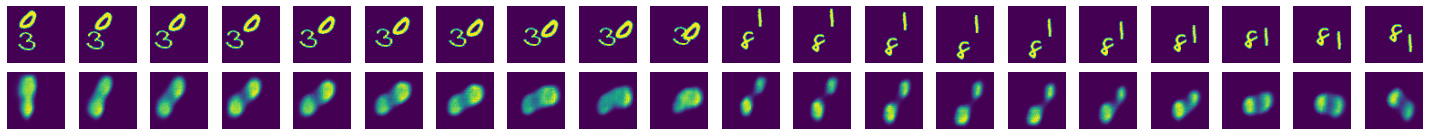

In [9]:
# test the reconstruction
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200


def plot_video_comparison(video,reconstructed_video):
    fig,ax = plt.subplots(2,20,figsize=(20,2))
    for i in range(20):
        ax[0,i].imshow(video[i,:,:])
        ax[0,i].axis('off')
    for i in range(20):
        ax[1,i].imshow(reconstructed_video[i,:,:])
        ax[1,i].axis('off')
    fig.tight_layout()

random_index = np.random.randint(1000)
sample = data[random_index]
sample = np.concatenate((data[random_index][:10],np.flip(data[random_index+1][:10],axis=0)))
sample_tensor = torch.reshape(torch.tensor(sample).float(),(20,1,64,64)).float().to(device)
y, mean, logvar, mean_prior, logvar_prior, z = vrnn.forward(sample_tensor)
reconstructed_sample = y.cpu().detach().numpy().reshape((20,64,64))


plot_video_comparison(sample,reconstructed_sample)

In [151]:
var_posterior = np.exp(logvar.cpu().detach().numpy().reshape((20,latent_size)))
var_prior = np.exp(logvar_prior.cpu().detach().numpy().reshape((20,latent_size)))
latent_var = z.cpu().detach().numpy().reshape((20,latent_size))

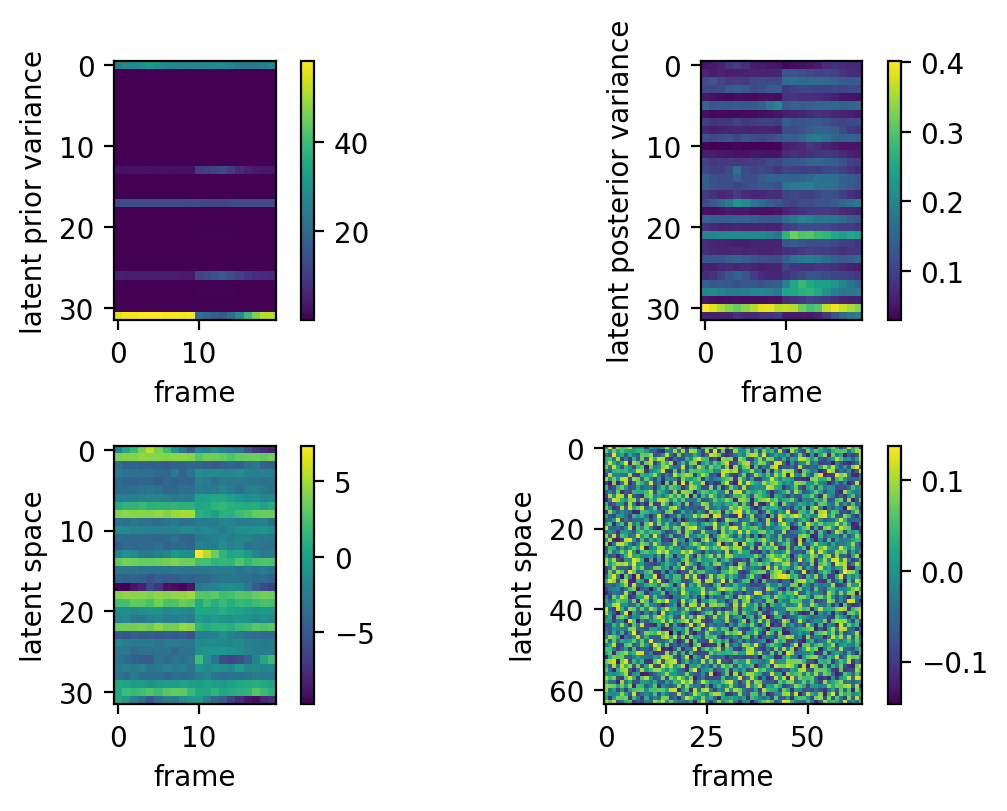

In [153]:
plt.figure()

plt.subplot(221)
plt.imshow(var_prior.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent prior variance')

plt.subplot(222)
plt.imshow(var_posterior.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent posterior variance')

plt.subplot(223)
plt.imshow(latent_var.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent space')

plt.subplot(224)
plt.imshow(vrnn.rnn.weight_hh_l0.cpu().detach().numpy())
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent space')

plt.tight_layout()
plt.show()

In [10]:
var_posterior_list = []
var_prior_list = []
latent_var_list = []

for i in tqdm(range(100)):
    random_index = np.random.randint(1000)
    sample = np.concatenate((data[random_index]))
    sample_tensor = torch.reshape(torch.tensor(sample).float(),(20,1,64,64)).float().to(device)
    y, mean, logvar, mean_prior, logvar_prior, z = vrnn.forward(sample_tensor)
    var_posterior = (logvar.cpu().detach().numpy().reshape((20,latent_size)))
    var_prior = (logvar_prior.cpu().detach().numpy().reshape((20,latent_size)))
    latent_var = z.cpu().detach().numpy().reshape((20,latent_size))

    sample_cut = np.concatenate((data[random_index][:10],data[random_index+1][10:]))
    sample_tensor_cut = torch.reshape(torch.tensor(sample_cut).float(),(20,1,64,64)).float().to(device)
    y_cut, mean_cut, logvar_cut, mean_prior_cut, logvar_prior_cut, z_cut = vrnn.forward(sample_tensor_cut)
    var_posterior_cut = (logvar_cut.cpu().detach().numpy().reshape((20,latent_size)))
    var_prior_cut = (logvar_prior_cut.cpu().detach().numpy().reshape((20,latent_size)))
    latent_var_cut = z_cut.cpu().detach().numpy().reshape((20,latent_size))

    var_posterior_list.append(var_posterior_cut - var_posterior )
    var_prior_list.append(var_prior_cut - var_prior)
    latent_var_list.append(latent_var_cut - latent_var)

var_posterior_mean = np.mean(var_posterior_list,axis=0)
var_prior_mean = np.mean(var_prior_list,axis=0)
latent_var_mean = np.mean(latent_var_list,axis=0)

100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


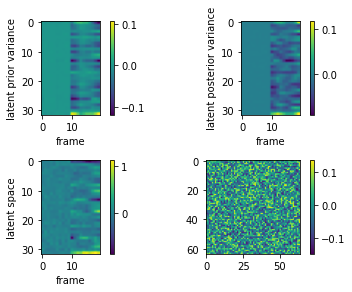

In [12]:
plt.figure()

plt.subplot(221)
plt.imshow(var_prior_mean.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent prior variance')

plt.subplot(222)
plt.imshow(var_posterior_mean.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent posterior variance')

plt.subplot(223)
plt.imshow(latent_var_mean.T)
plt.colorbar()
plt.xlabel('frame')
plt.ylabel('latent space')

plt.subplot(224)
plt.imshow(vrnn.rnn.weight_hh_l0.cpu().detach().numpy())
plt.colorbar()

plt.tight_layout()
plt.show()